<a href="https://colab.research.google.com/github/aruaru0/unet_sr/blob/main/u_net_sr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリの読み込み

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# モデル定義

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList([
            self.conv_block(in_channels, 64),
            self.conv_block(64, 128),
            self.conv_block(128, 256),
            self.conv_block(256, 512)
        ])

        self.bottleneck = self.conv_block(512, 1024)

        self.decoder = nn.ModuleList([
            self.conv_block(1024+512, 512),
            self.conv_block(512+256, 256),
            self.conv_block(256+128, 128),
            nn.Sequential(
                nn.Conv2d(128+64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            )
        ])

    def conv_block(self, in_channels, out_channels):
        """Conv-ReLUブロックを生成するユーティリティ関数"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []

        # Encoder
        for enc in self.encoder:
            x = enc(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(2)(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for i, dec in enumerate(self.decoder):
            x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)(x)

            if i < len(skip_connections):
                x = torch.cat((x, skip_connections[-(i + 1)]), dim=1)  # skip connection
            x = dec(x)

        return x

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=5, padding=2)

        for m in self.modules():
            if isinstance(m, (nn.Conv2d)):
                nn.init.normal_(m.weight, mean=0, std=0.001)
                nn.init.constant_(m.bias, val=0)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        return x

# データセットを定義

In [4]:
class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.image_files = glob.glob(os.path.join(root_dir, "*.png"))
        self.crop =  transforms.RandomCrop(256)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_files[idx])

        image = Image.open(img_name).convert('L')  # グレースケール画像
        image = self.crop(image)

        # ボケた画像を作成
        # Image.NEAREST Image.BOX Image.BILINEAR Image.HAMMING Image.BICUBIC Image.LANCZOS
        low_res = image.resize((image.size[0] // 2, image.size[1] // 2), Image.BILINEAR)
        low_res = low_res.resize(image.size, Image.BILINEAR)

        if self.transform:
            image = self.transform(image)
            low_res = self.transform(low_res)

        return low_res, image

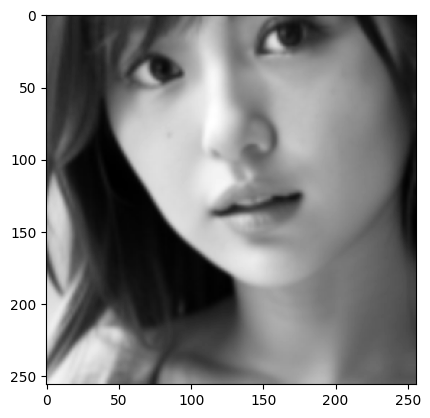

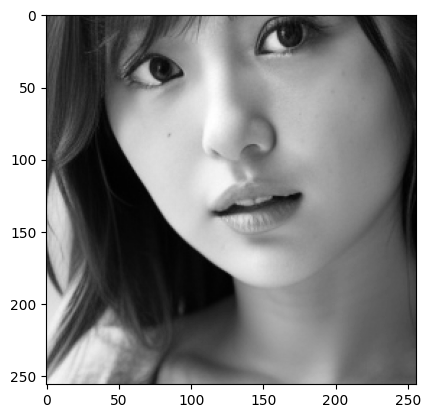

In [26]:
transform = transforms.Compose([
    transforms.RandomCrop(256),
    transforms.ToTensor(),
])
dataset = SuperResolutionDataset(root_dir='train_data', transform=transform)
low, hi = dataset[1]
plt.imshow(low.squeeze(), cmap='gray')
plt.show()
plt.imshow(hi.squeeze(), cmap='gray')
plt.show()

# 学習用の関数定義

In [6]:
def train(model, dataloader, criterion, optimizer, num_epochs=20):
    model.train()

    for epoch in range(num_epochs):
        for i, (low_res, high_res) in enumerate(dataloader):
            optimizer.zero_grad()

            # GPU使用のため
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
          print(f'Epoch [{epoch + 1}/{num_epochs}],  Loss: {loss.item():.6f}')

# モデル生成・学習

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# モデル、損失関数、最適化手法の初期化
model = UNet(in_channels=1, out_channels=1).to(device)
# model = SRCNN(in_channels=1, out_channels=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [8]:
# データ変換
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# データセットとデータローダーの作成
dataset = SuperResolutionDataset(root_dir='train_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# モデルのトレーニング
train(model, dataloader, criterion, optimizer, num_epochs=2000)

# モデルの保存
torch.save(model.state_dict(), 'unet_super_resolution.pth')

Epoch [1/2000],  Loss: 0.268597
Epoch [11/2000],  Loss: 0.268679
Epoch [21/2000],  Loss: 0.049778
Epoch [31/2000],  Loss: 0.041591
Epoch [41/2000],  Loss: 0.027210
Epoch [51/2000],  Loss: 0.013986
Epoch [61/2000],  Loss: 0.008761
Epoch [71/2000],  Loss: 0.006517
Epoch [81/2000],  Loss: 0.005540
Epoch [91/2000],  Loss: 0.004210
Epoch [101/2000],  Loss: 0.005637
Epoch [111/2000],  Loss: 0.004441
Epoch [121/2000],  Loss: 0.005451
Epoch [131/2000],  Loss: 0.001902
Epoch [141/2000],  Loss: 0.004167
Epoch [151/2000],  Loss: 0.002873
Epoch [161/2000],  Loss: 0.003623
Epoch [171/2000],  Loss: 0.001821
Epoch [181/2000],  Loss: 0.003010
Epoch [191/2000],  Loss: 0.001351
Epoch [201/2000],  Loss: 0.002098
Epoch [211/2000],  Loss: 0.003042
Epoch [221/2000],  Loss: 0.002220
Epoch [231/2000],  Loss: 0.002448
Epoch [241/2000],  Loss: 0.002199
Epoch [251/2000],  Loss: 0.002313
Epoch [261/2000],  Loss: 0.002485
Epoch [271/2000],  Loss: 0.002613
Epoch [281/2000],  Loss: 0.003091
Epoch [291/2000],  Loss: 

# 推論（テスト）

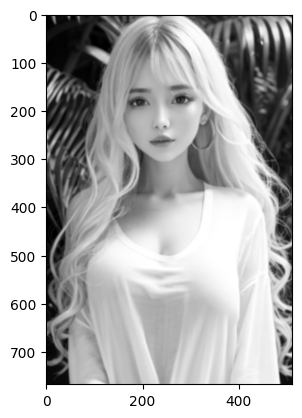

In [13]:
image_file = "datas/girl.png"
image = Image.open(image_file).convert('L')  # グレースケール画像

# ボケた画像を作成
low_res = image.resize((image.size[0] // 2, image.size[1] // 2), Image.BILINEAR)
low_res = low_res.resize(image.size, Image.BILINEAR)
plt.imshow(low_res, cmap='gray')
plt.show()

torch.Size([1, 1, 768, 512])


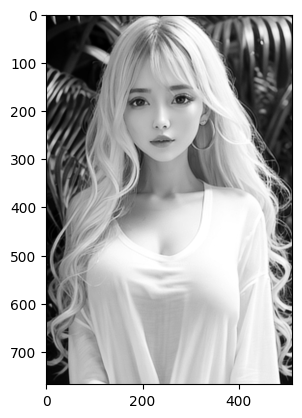

In [14]:
img = transform(low_res).unsqueeze(0).to(device)
print(img.shape)
model.eval()
with torch.no_grad():
    predicted_image = model(img)

predicted_image = predicted_image.squeeze().cpu().numpy()
predicted_image = np.clip(predicted_image, 0, 1)  # 値を0-1にクリップ

plt.imshow(predicted_image, cmap='gray')
plt.show()

In [15]:
## SNRを計算する
def calc_snr(original_image, noisy_image):
    """
    2つのPIL Imageを入力として、SNRを計算する
    original_image: PIL Image (元画像)
    noisy_image: PIL Image (ノイズのある画像)
    """

    # PIL Image を NumPy 配列に変換
    original_image_np = np.array(original_image, dtype=np.float32)
    noisy_image_np = np.array(noisy_image, dtype=np.float32)

    # 元画像とノイズ画像の差を計算
    noise = noisy_image_np - original_image_np

    # 信号（元画像）のパワーを計算
    signal_power = np.mean(original_image_np ** 2)

    # ノイズのパワーを計算
    noise_power = np.mean(noise ** 2)

    # SNRを計算（10 * log10(signal/noise)）
    if noise_power == 0:
        return float('inf')  # ノイズが全くない場合、SNRは無限大
    else:
        snr = 10 * np.log10(signal_power / noise_power)

    return snr

result = transforms.functional.to_pil_image(predicted_image)
print("low_res SNR = ", calc_snr(image, low_res))
print("result  SNR = ", calc_snr(image, result))

low_res SNR =  26.314213275909424
result  SNR =  28.841605186462402


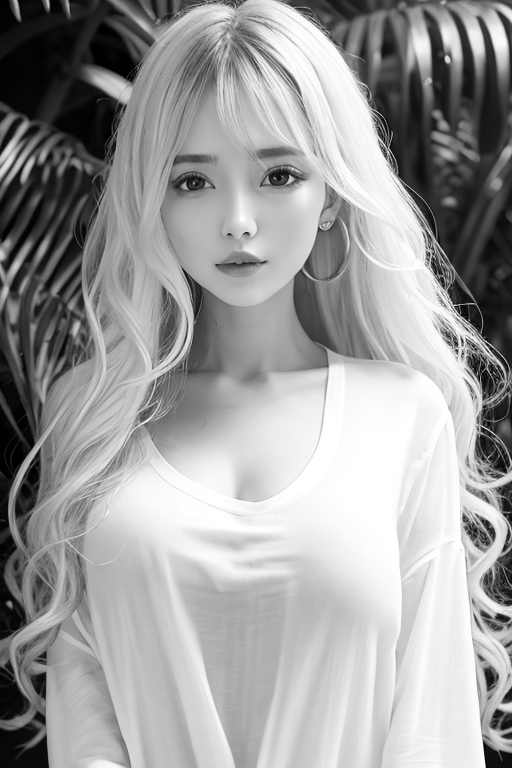

In [17]:
image

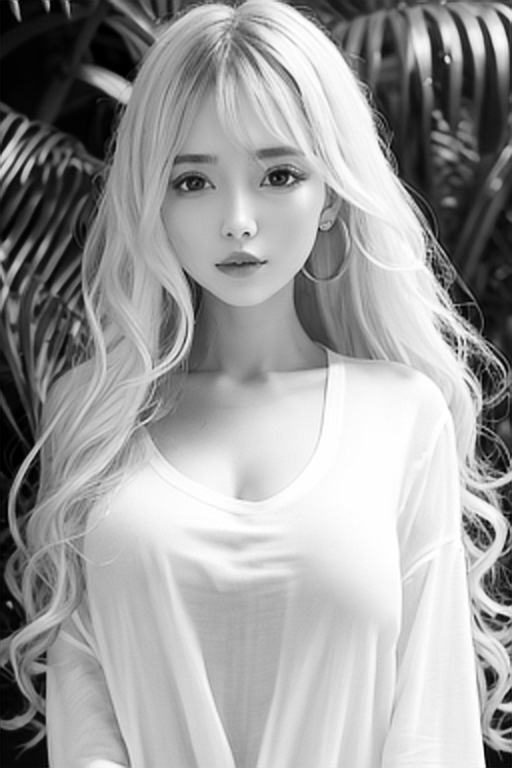

In [18]:
result

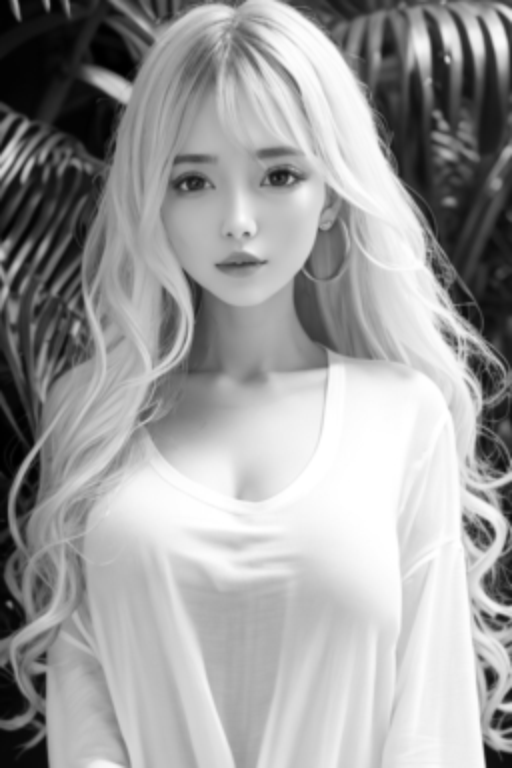

In [19]:
low_res